In [1]:
import pyspark
from pyspark.sql import SparkSession

#Starting Spark Session
spark = SparkSession.builder.getOrCreate()


In [2]:
import pyspark.sql.functions as F
from pyspark.sql.types import *

#Getting Borough data
borough_data = spark.read.csv('data/taxi _zone_lookup.csv', header=True)


#Get yellow taxis trip data from 2020
taxis_trips = spark.read.csv('data/tripdata/', header=True)

def get_month(value):
  return value.split("-")[1]
    
    
#Convert to a UDF Function (parameters: the function and its return type)
udf_get_month = F.udf(get_month, StringType())

#Add Month column to the dataset
trips = taxis_trips.withColumn("Month", udf_get_month("tpep_pickup_datetime"))


In [3]:
#Join trip info with borough data
borough_trips = trips.join(borough_data, trips.PULocationID == borough_data.LocationID)
#borough_trips.show()

In [4]:
#Casting passenger_count to Integer, since it is string
casted_df = borough_trips.withColumn("passenger_count", borough_trips.passenger_count.cast(IntegerType()))

#Grouping by month and summing the number os passengers
#casted_df.groupBy("Month").agg(F.sum('passenger_count').alias('Passengers')).orderBy("Passengers").show()

## Janelas de tempo - viagens com mais passageiros

In [5]:
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number, col

windowSpec  = Window.partitionBy("Borough").orderBy(col("passenger_count").desc())
start_end_times_df = casted_df.select(col("tpep_pickup_datetime").cast("timestamp"), \
                                   col("tpep_dropoff_datetime").cast("timestamp"), \
                                   col("Borough"),col("passenger_count"))

   
#Convert to a UDF Function (parameters: the function and its return type)
udf_hour = F.udf(lambda x: x.hour, IntegerType())

#Add start_time and end_time columns to the dataframe
start_end_times_df = start_end_times_df.withColumn("start_hour", udf_hour("tpep_pickup_datetime"))
start_end_times_df = start_end_times_df.withColumn("end_hour", udf_hour("tpep_dropoff_datetime"))
start_end_times_df.show()


+--------------------+---------------------+---------+---------------+----------+--------+
|tpep_pickup_datetime|tpep_dropoff_datetime|  Borough|passenger_count|start_hour|end_hour|
+--------------------+---------------------+---------+---------------+----------+--------+
| 2020-11-01 00:37:37|  2020-11-01 00:51:45|Manhattan|              1|         0|       0|
| 2020-11-01 00:17:41|  2020-11-01 00:32:22|Manhattan|              2|         0|       0|
| 2020-11-01 00:42:29|  2020-11-01 01:09:08|Manhattan|              2|         0|       1|
| 2020-11-01 00:28:59|  2020-11-02 00:00:00|   Queens|              1|         0|       0|
| 2020-11-01 00:13:26|  2020-11-01 00:22:59|Manhattan|              1|         0|       0|
| 2020-11-01 00:09:36|  2020-11-01 00:20:55|Manhattan|              1|         0|       0|
| 2020-10-31 23:57:50|  2020-11-01 00:28:08|   Queens|              1|        23|       0|
| 2020-11-01 00:32:28|  2020-11-01 00:47:34|Manhattan|              1|         0|       0|

In [56]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def set_labels_title(ax, number, window):
    title = "Boroughs with biggest number of passengers - " + window + " window"
    ax.set_ylabel('Boroughs')  # Add a y-label to the axes.
    ax.set_title(title)  # Add a title to the axes.




## Janela de tempo: 0 às 5h

In [20]:
range_zero_to_five = start_end_times_df.filter((col('start_hour') >= 0) & (col('start_hour') < 5) & (col('end_hour') < 5))

#from pyspark.sql.window import Window
from pyspark.sql.functions import col, row_number

#window_borough = Window.partitionBy("Borough").orderBy(col("passenger_count").desc())

#range_zero_to_five = range_zero_to_five.withColumn("row",row_number().over(window_borough)) \
#  .filter(col("row") <= 10) 

#range_zero_to_five.show()

result = range_zero_to_five.groupBy("Borough").agg(F.sum("passenger_count").alias("total_passengers")).orderBy(col("total_passengers").desc())


In [57]:
result_df = result.toPandas()


   index        Borough  total_passengers
0      0      Manhattan           1996020
1      1         Queens            109293
2      2       Brooklyn             41983
3      3        Unknown             18670
4      4          Bronx              7396
5      5  Staten Island               329
6      6            EWR               150


<ipython-input-58-4f4fa22b6e7a>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(count_list)


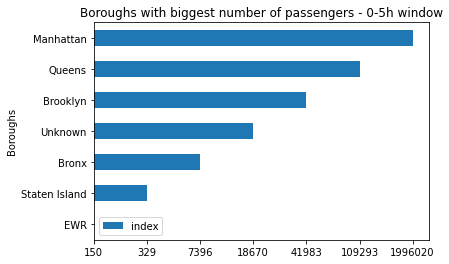

In [58]:

count_list = result_df["total_passengers"].tolist()
count_list.reverse()

borough_list = result_df["Borough"].tolist()
borough_list.reverse()

y_pos = np.arange(len(borough_list))
result_df = result_df.reset_index()
print(result_df)

ax = result_df.plot(kind='barh',x='total_passengers', y='index')
ax.set_yticks(y_pos)
ax.set_yticklabels(borough_list)
ax.set_xticklabels(count_list)
set_labels_title(ax, 1, "0-5h")


## Janela de tempo: 5h às 11h

In [ ]:

range_five_to_eleven = start_end_times_df.filter((col('start_hour') >= 5) & (col('start_hour') < 11) & (col('end_hour') < 11))

result2 = range_five_to_eleven.groupBy("Borough").agg(F.sum("passenger_count").alias("total_passengers")).orderBy(col("total_passengers").desc())

#result2_df = result2.toPandas()
#ax = result2_df.plot(kind='bar',x='total_passengers', y='Borough')
#set_labels_title(ax, 1)


## Janela de tempo: 11h às 14h

In [ ]:
range_eleven_to_fourteen = start_end_times_df.filter((col('start_hour') >= 11) & (col('start_hour') < 14) & (col('end_hour') < 14))

#result3 = range_eleven_to_fourteen.groupBy("Borough").agg(F.sum("passenger_count").alias("total_passengers")).orderBy(col("total_passengers").desc())

#result3_df = result3.toPandas()
#ax = result3_df.plot(kind='bar',x='total_passengers', y='Borough')
#set_labels_title(ax, 1)


## Janela de tempo: 14h às 17h

In [ ]:
range_fourteen_to_seventeen = start_end_times_df.filter((col('start_hour') >= 14) & (col('start_hour') < 17) & (col('end_hour') < 17))

#result4_df = result4.toPandas()
#ax = result4_df.plot(kind='bar',x='total_passengers', y='Borough')
#set_labels_title(ax, 1)


## Janela de tempo: 17h às 21h

In [ ]:
range_seventeen_twenty_one = start_end_times_df.filter((col('start_hour') >= 17) & (col('start_hour') < 21) & (col('end_hour') < 21))

## Janela de tempo: 21h às 24h

In [ ]:
range_twenty_one_twenty_four = start_end_times_df.filter((col('start_hour') >= 21) & (col('start_hour') < 24) & (col('end_hour') < 24))